<a href="https://colab.research.google.com/github/Seb207/Market-Context-Project/blob/main/Irrationality%20Index/DL_Index_Outline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup (Colab / Local)

# Deep Learning for Index Outline

Outline for deep learning model to analze market factors and output irrationality index.

Model: Transformer

Data_Format: history data in second

- Positional Embedding Class
- Transformer Encoder Block Class
- Prediction Head Class
- Irrationality Index Class
- Model Manager Class

# Hypothesis

**Factors**
- Volatility: VIX (moving avg. - 20 days)
- Volume: Trading Volume (periodic average - 20 days)
- Fixed Income (macro): US bond rate momentum
- Periodicity: past rate of return (20, 60, 120 days)
- Small vs. Big performace: (QQQ -> factor: IWM, IWM -> factor: QQQ) rate of return
-

**Tested Data**
- SPY (S&P 500)
- QQQ (Nasdaq)
- DIA (Dow Jones)
- IWM (Russell 2000)
- Individual stocks

1.

# Import Libraries

In [6]:
import gc
import os

try:
    import optuna
    from optuna.integration import TFKerasPruningCallback
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'optuna', '-q'])
    import optuna
    from optuna.integration import TFKerasPruningCallback

import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout,
    LayerNormalization, MultiHeadAttention,
    GlobalAveragePooling1D
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, mean_absolute_percentage_error

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Define model directory
MODEL_DIR = "../trained_model"
os.makedirs(MODEL_DIR, exist_ok=True)

# Data Preprocessing

Problem 1:
- As factors have each different absolute values, output could be affected by its absolute value if directly used as input.

Solution:
- Used data normalization (z-score)

In [9]:
df = pd.read_csv("/content/Data/1424_daily_cleaned.csv", index_col=0, parse_dates=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2501 entries, 2015-01-02 to 2024-12-31
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   QQQ_Price_Close  2501 non-null   float64
 1   QQQ_Volume       2501 non-null   float64
 2   SPY_Price_Close  2501 non-null   float64
 3   SPY_Volume       2501 non-null   float64
 4   US10_Mid_Price   2501 non-null   float64
 5   US10_Mid_Yld     2501 non-null   float64
 6   US30_Mid_Price   2501 non-null   float64
 7   US30_Mid_Yld     2501 non-null   float64
 8   GLD_Price_Close  2501 non-null   float64
 9   GLD_Volume       2501 non-null   float64
 10  IWM_Price_Close  2501 non-null   float64
 11  IWM_Volume       2501 non-null   float64
 12  VIX              2501 non-null   float64
dtypes: float64(13)
memory usage: 273.5 KB


In [11]:
input_features = ['QQQ_Volume', 'US10_Mid_Yld', 'GLD_Price_Close', 'IWM_Price_Close', 'VIX']
target = 'QQQ_Price_Close' # Assume the target to be the price data in this case.

In [12]:
correlation_df = df.corr()

print(correlation_df[target].sort_values(ascending=False))

QQQ_Price_Close    1.000000
SPY_Price_Close    0.993463
GLD_Price_Close    0.947892
IWM_Price_Close    0.897019
US10_Mid_Yld       0.452836
US30_Mid_Yld       0.397922
QQQ_Volume         0.229553
VIX                0.123486
IWM_Volume         0.075931
GLD_Volume        -0.077556
US30_Mid_Price    -0.109676
US10_Mid_Price    -0.131958
SPY_Volume        -0.307432
Name: QQQ_Price_Close, dtype: float64


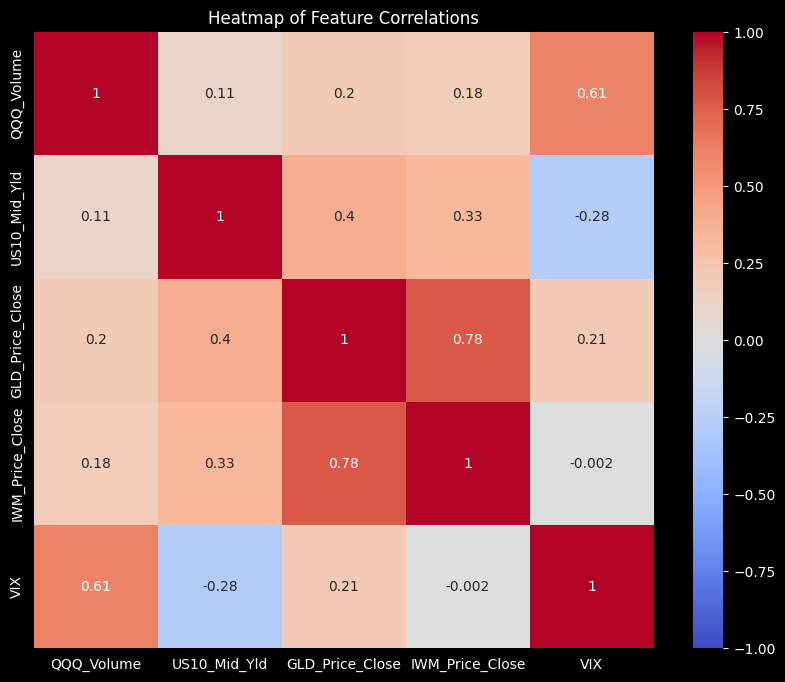

In [13]:
correlation_matrix = df[input_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0)
plt.title('Heatmap of Feature Correlations')
plt.show()

In [14]:
vif = [float(variance_inflation_factor(df[1:].values, i)) for i in range(df.shape[1])]

vif_dict = dict(zip(df.columns, vif))

vif_df = pd.DataFrame({
    'Feature': df.columns,
    'VIF': vif
}).sort_values(by='VIF', ascending=False)

vif_df

,Feature,VIF
4,US10_Mid_Price,2736.151138
2,SPY_Price_Close,2386.064651
6,US30_Mid_Price,1499.176062
7,US30_Mid_Yld,884.037685
0,QQQ_Price_Close,741.676079
5,US10_Mid_Yld,498.059182
8,GLD_Price_Close,441.222283
10,IWM_Price_Close,333.775748
12,VIX,24.815512
3,SPY_Volume,23.813327


In [15]:
selected_features = [target] + input_features
data_array = df[selected_features].values
num_features = len(selected_features)

In [16]:
def create_dataset(dataset, look_back=1, target_col_index=0):
    """
    Args:
        dataset: entire dataset (n_samples, n_features)
        look_back: length of sequence (# of days to look back for input)
        target_col_index: target column index in the dataset (0-based)

    Returns:
        X: (n_samples, look_back, n_features) - input sequences
        Y: (n_samples,) - target value

    Example (look_back=3, data 10개):
        X[0] = data[0:3]  → Y[0] = data[3, target_col]
        X[1] = data[1:4]  → Y[1] = data[4, target_col]
        ...
        X[6] = data[6:9]  → Y[6] = data[9, target_col]
    """
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        seq_input = dataset[i: (i + look_back), :]
        X.append(seq_input)
        seq_target = dataset[i + look_back, target_col_index]
        Y.append(seq_target)
    return np.array(X), np.array(Y)

In [17]:
look_back = 20 # days 20 days --> 1 month

# ============================================================
# Data Split Strategy
# ============================================================
# 1. First, split raw data into train+val and test (chronological order)
# 2. Apply create_dataset() to each split separately (prevents data leakage)
# 3. Use TimeSeriesSplit for cross-validation during hyperparameter tuning
# ============================================================

total_len = len(data_array)

# Hold out test set (last 20% of data)
test_ratio = 0.2
test_start = int(total_len * (1 - test_ratio))

# Split: train_val (80%) and test (20%)
train_val_data = data_array[:test_start]
test_data = data_array[test_start:]

print(f"Raw Data Split:")
print(f"  Train+Val: {len(train_val_data)} samples (index 0 ~ {test_start-1})")
print(f"  Test:      {len(test_data)} samples (index {test_start} ~ {total_len-1})")

# Apply create_dataset() to each split
X_train_val, Y_train_val = create_dataset(train_val_data, look_back, target_col_index=0)
X_test, Y_test = create_dataset(test_data, look_back, target_col_index=0)

# Further split train_val into train and val for final model training
val_ratio_of_train_val = 0.25  # 25% of train_val = 20% of total
val_size = int(len(X_train_val) * val_ratio_of_train_val)

X_train = X_train_val[:-val_size]
Y_train = Y_train_val[:-val_size]
X_val = X_train_val[-val_size:]
Y_val = Y_train_val[-val_size:]

print(f"\nAfter create_dataset():")
print(f"  X_train_val: {X_train_val.shape} (for CV in RandomizedSearchCV)")
print(f"  X_train:     {X_train.shape} (for final model training)")
print(f"  X_val:       {X_val.shape} (for final model validation)")
print(f"  X_test:      {X_test.shape} (for final evaluation)")

# TimeSeriesSplit configuration for cross-validation
N_SPLITS_CV = 5
print(f"\nTimeSeriesSplit folds preview (n_splits={N_SPLITS_CV}):")
tscv_preview = TimeSeriesSplit(n_splits=N_SPLITS_CV)
for i, (train_idx, val_idx) in enumerate(tscv_preview.split(X_train_val)):
    print(f"  Fold {i+1}: Train {len(train_idx)} samples, Val {len(val_idx)} samples")

Raw Data Split:
  Train+Val: 2000 samples (index 0 ~ 1999)
  Test:      501 samples (index 2000 ~ 2500)

After create_dataset():
  X_train_val: (1980, 20, 6) (for CV in RandomizedSearchCV)
  X_train:     (1485, 20, 6) (for final model training)
  X_val:       (495, 20, 6) (for final model validation)
  X_test:      (481, 20, 6) (for final evaluation)

TimeSeriesSplit folds preview (n_splits=5):
  Fold 1: Train 330 samples, Val 330 samples
  Fold 2: Train 660 samples, Val 330 samples
  Fold 3: Train 990 samples, Val 330 samples
  Fold 4: Train 1320 samples, Val 330 samples
  Fold 5: Train 1650 samples, Val 330 samples


In [18]:
# Verify data time range
print(f"\nData Time Range:")
print(f"  Train+Val period: {df.index[0]} ~ {df.index[test_start-1]}")
print(f"  Test period:      {df.index[test_start]} ~ {df.index[total_len-1]}")


Data Time Range:
  Train+Val period: 2015-01-02 00:00:00 ~ 2022-12-28 00:00:00
  Test period:      2022-12-29 00:00:00 ~ 2024-12-31 00:00:00


In [19]:
# ============================================================
# Feature Scaling (Complete Look-Ahead Bias Prevention)
# ============================================================
# Problem: Fitting scaler on entire training data uses future information
# Solution: Expanding Window approach - scale each sample using only past data
#
# Method 1: Per-Sample Expanding Window (accurate but slow)
# Method 2: Initial Period Scaling (practical compromise)
# ============================================================

n_samples_train, n_timesteps, n_features_scaled = X_train.shape

# Configuration: Select scaling method
USE_EXPANDING_WINDOW = True  # True: Complete look-ahead prevention, False: Fast approximation

if USE_EXPANDING_WINDOW:
    print("=" * 60)
    print("Using Expanding Window Scaling (No Look-Ahead Bias)")
    print("=" * 60)

    # ============================================================
    # Expanding Window Scaling for Training Data
    # ============================================================
    # For each sample i: fit scaler using samples 0 to i-1 only
    # Requires minimum initial period (min_periods)
    # ============================================================

    min_periods = 50  # Apply expanding window after first 50 samples

    X_train_scaled = np.zeros_like(X_train, dtype=np.float32)
    Y_train_scaled = np.zeros_like(Y_train, dtype=np.float32)

    print(f"Processing {n_samples_train} training samples with expanding window...")

    for i in range(n_samples_train):
        if i < min_periods:
            # Initial period: Use first min_periods samples for scaling (warm-up)
            # These samples should be excluded or handled with caution
            past_X = X_train[:min_periods].reshape(-1, n_features_scaled)
            past_Y = Y_train[:min_periods]
        else:
            # Expanding window: Use all data before current sample
            past_X = X_train[:i].reshape(-1, n_features_scaled)
            past_Y = Y_train[:i]

        # Fit scaler using data up to current time point
        scaler_temp = StandardScaler()
        scaler_temp.fit(past_X)

        scaler_y_temp = StandardScaler()
        scaler_y_temp.fit(past_Y.reshape(-1, 1))

        # Scale current sample
        X_train_scaled[i] = scaler_temp.transform(
            X_train[i].reshape(-1, n_features_scaled)
        ).reshape(n_timesteps, n_features_scaled)

        Y_train_scaled[i] = scaler_y_temp.transform([[Y_train[i]]])[0, 0]

    # Remove initial warm-up period (optional)
    REMOVE_WARMUP = True
    if REMOVE_WARMUP:
        X_train_scaled = X_train_scaled[min_periods:]
        Y_train_scaled = Y_train_scaled[min_periods:]
        X_train = X_train[min_periods:]
        Y_train = Y_train[min_periods:]
        n_samples_train = len(X_train)
        print(f"  Removed {min_periods} warm-up samples")

    print(f"  Training samples after processing: {n_samples_train}")

    # ============================================================
    # Validation/Test data: Scale using full training data statistics
    # (Appropriate since training is complete before deployment)
    # ============================================================
    X_train_full_2d = X_train.reshape(-1, n_features_scaled)
    scaler = StandardScaler()
    scaler.fit(X_train_full_2d)

    scaler_y = StandardScaler()
    scaler_y.fit(Y_train.reshape(-1, 1))

    # Scale validation and test data
    X_train_val_scaled = scaler.transform(X_train_val.reshape(-1, n_features_scaled)).reshape(X_train_val.shape)
    X_val_scaled = scaler.transform(X_val.reshape(-1, n_features_scaled)).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, n_features_scaled)).reshape(X_test.shape)

    Y_train_val_scaled = scaler_y.transform(Y_train_val.reshape(-1, 1)).flatten()
    Y_val_scaled = scaler_y.transform(Y_val.reshape(-1, 1)).flatten()
    Y_test_scaled = scaler_y.transform(Y_test.reshape(-1, 1)).flatten()

    print(f"\n✅ Look-Ahead Bias Prevention Complete:")
    print(f"   - Training: Expanding window scaling (per-sample)")
    print(f"   - Val/Test: Scaled with full training data statistics")

else:
    # ============================================================
    # Fast approximation: Fit scaler using only first N% of data
    # ============================================================
    print("=" * 60)
    print("Using Initial Period Scaling (Fast Approximation)")
    print("=" * 60)

    # Fit scaler using only first 50% of training data
    init_ratio = 0.5
    init_size = int(n_samples_train * init_ratio)

    X_init_2d = X_train[:init_size].reshape(-1, n_features_scaled)
    scaler = StandardScaler()
    scaler.fit(X_init_2d)

    scaler_y = StandardScaler()
    scaler_y.fit(Y_train[:init_size].reshape(-1, 1))

    X_train_scaled = scaler.transform(X_train.reshape(-1, n_features_scaled)).reshape(X_train.shape)
    X_train_val_scaled = scaler.transform(X_train_val.reshape(-1, n_features_scaled)).reshape(X_train_val.shape)
    X_val_scaled = scaler.transform(X_val.reshape(-1, n_features_scaled)).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, n_features_scaled)).reshape(X_test.shape)

    Y_train_scaled = scaler_y.transform(Y_train.reshape(-1, 1)).flatten()
    Y_train_val_scaled = scaler_y.transform(Y_train_val.reshape(-1, 1)).flatten()
    Y_val_scaled = scaler_y.transform(Y_val.reshape(-1, 1)).flatten()
    Y_test_scaled = scaler_y.transform(Y_test.reshape(-1, 1)).flatten()

    print(f"⚠️  Approximate Look-Ahead Bias Prevention:")
    print(f"   Scaler fitted on first {init_ratio*100:.0f}% of training data: {init_size} samples")
    print(f"   Note: Later training samples may still have minor look-ahead bias")

Using Expanding Window Scaling (No Look-Ahead Bias)
Processing 1485 training samples with expanding window...
  Removed 50 warm-up samples
  Training samples after processing: 1435

✅ Look-Ahead Bias Prevention Complete:
   - Training: Expanding window scaling (per-sample)
   - Val/Test: Scaled with full training data statistics


In [20]:
print(f"X_train shape: {X_train_scaled.shape}")
print(f"Y_train shape: {Y_train_scaled.shape}")
print(f"X_val shape: {X_val_scaled.shape}")
print(f"Y_val shape: {Y_val_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"Y_test shape: {Y_test_scaled.shape}")

X_train shape: (1435, 20, 6)
Y_train shape: (1435,)
X_val shape: (495, 20, 6)
Y_val shape: (495,)
X_test shape: (481, 20, 6)
Y_test shape: (481,)


# Hyperparameters

**Model Architecture**
- input_dim: number of factors
- seq_len: length of data processed in the model at once
- d_model: dimension of the model
- num_heads: number of heads for multi-head attention (should be divisor of d_model)
- d_ff: inner dimension of feed forward (4x of d_model in usual)
- num_layers: number of transformer encoder block (depth of model)
- output_dim: output dimension

**Training and Normalization**
- dropout_rate
- learning_rate
- batch_size

# Transformer Encoder Block Class





In [21]:
class TransformerBlock(tf.keras.layers.Layer):
    """
    Transformer Encoder Block with Pre-Layer Normalization.

    Note: Causal masking is disabled by default for encoder-based prediction.
    For time series forecasting where we use the entire look_back window
    to predict the next step, full attention is appropriate.
    """
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        if embed_dim % num_heads != 0:
            raise ValueError("`embed_dim` must be divisible by `num_heads`.")
        key_dim = embed_dim // num_heads
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="gelu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        # Pre-LN: LayerNorm before attention
        x_norm = self.layernorm1(inputs)
        # Full attention (no causal mask) - standard for encoder
        attn_output = self.att(query=x_norm, value=x_norm, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output  # Residual connection

        # Pre-LN: LayerNorm before FFN
        out1_norm = self.layernorm2(out1)
        ffn_output = self.ffn(out1_norm)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output  # Residual connection

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'dropout_rate': self.dropout_rate
        })
        return config

# Positional Embedding Class

In [22]:
class LearnablePositionalEmbedding(tf.keras.layers.Layer):
    """
    Learnable Positional Embedding (modern approach).

    Unlike fixed sinusoidal encoding, this learns position representations
    during training, which can be more flexible for specific tasks.

    """
    def __init__(self, max_len, embed_dim, **kwargs):
        super(LearnablePositionalEmbedding, self).__init__(**kwargs)
        self.max_len = max_len
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.pos_embedding = self.add_weight(
            name='pos_embedding',
            shape=(self.max_len, self.embed_dim),
            initializer='glorot_uniform',  # Xavier initialization
            trainable=True
        )
        super(LearnablePositionalEmbedding, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, seq_len, embed_dim)
        seq_len = tf.shape(x)[1]
        return x + self.pos_embedding[:seq_len, :]

    def get_config(self):
        config = super().get_config()
        config.update({'max_len': self.max_len, 'embed_dim': self.embed_dim})
        return config


class SinusoidalPositionalEncoding(tf.keras.layers.Layer):
    """
    Fixed Sinusoidal Positional Encoding (original Transformer approach).

    Kept as an alternative option. Good for:
    - Sequences longer than training data
    - When you want position info without additional parameters
    """
    def __init__(self, max_len, embed_dim, **kwargs):
        super(SinusoidalPositionalEncoding, self).__init__(**kwargs)
        self.max_len = max_len
        self.embed_dim = embed_dim

    def build(self, input_shape):
        pos = np.arange(self.max_len)[:, np.newaxis]
        i = np.arange(self.embed_dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(self.embed_dim))
        angle_rads = pos * angle_rates

        pos_encoding = np.zeros_like(angle_rads, dtype=np.float32)
        pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = pos_encoding[np.newaxis, ...]
        self.pos_encoding = tf.constant(pos_encoding, dtype=tf.float32)
        super(SinusoidalPositionalEncoding, self).build(input_shape)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]

    def get_config(self):
        config = super().get_config()
        config.update({'max_len': self.max_len, 'embed_dim': self.embed_dim})
        return config

# Transformer Model Building Function

In [23]:
def build_transformer_model(look_back_size, num_features,
                           embed_dim=64, num_heads=4,
                           ff_dim=128, num_transformer_blocks=2,
                           dropout_rate=0.2, learning_rate=0.001,
                           use_learnable_pe=True):
    """
    Build a Transformer model for time series prediction.

    Modern architecture features:
    - Pre-Layer Normalization (more stable training)
    - GELU activation in FFN
    - Learnable positional embeddings (default) or sinusoidal
    - Final LayerNorm after transformer blocks
    - Causal masking for autoregressive prediction

    Args:
        look_back_size: sequence length (number of time steps)
        num_features: number of input features
        embed_dim: embedding dimension (must be divisible by num_heads)
        num_heads: number of attention heads
        ff_dim: feed-forward network hidden dimension
        num_transformer_blocks: number of transformer encoder layers
        dropout_rate: dropout rate for regularization
        learning_rate: optimizer learning rate
        use_learnable_pe: if True, use learnable positional embedding; else sinusoidal
    """
    inputs = Input(shape=(look_back_size, num_features))

    # Input projection to embed_dim
    x = Dense(embed_dim, kernel_initializer='glorot_uniform')(inputs)

    # Positional encoding
    if use_learnable_pe:
        x = LearnablePositionalEmbedding(look_back_size, embed_dim)(x)
    else:
        x = SinusoidalPositionalEncoding(look_back_size, embed_dim)(x)

    # Initial dropout
    x = Dropout(dropout_rate)(x)

    # Transformer encoder blocks
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)

    # Final LayerNorm
    x = LayerNormalization(epsilon=1e-6)(x)

    # Global average pooling over time dimension
    x = GlobalAveragePooling1D()(x)

    # Prediction head with residual-like structure
    x = Dense(64, activation='gelu', kernel_initializer='glorot_uniform')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(32, activation='gelu', kernel_initializer='glorot_uniform')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear', kernel_initializer='glorot_uniform')(x)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=1e-5,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.Huber(delta=1.0),
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae']
    )
    return model

# Training & Tuning Data

In [24]:
def create_objective(X_train, Y_train, X_val, Y_val, look_back, num_features):
    """
    Create Optuna objective function with data closure.
    """
    def objective(trial):
        # Clear session to prevent memory leak
        tf.keras.backend.clear_session()

        # Hyperparameter search space
        embed_dim = trial.suggest_categorical('embed_dim', [64, 128, 256])
        num_heads = trial.suggest_categorical('num_heads', [2, 4, 8])
        ff_dim = trial.suggest_categorical('ff_dim', [256, 512])
        num_transformer_blocks = trial.suggest_int('num_transformer_blocks', 2, 4)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4, step=0.05)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True)
        use_learnable_pe = trial.suggest_categorical('use_learnable_pe', [True, False])
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

        # Build model
        model = build_transformer_model(
            look_back_size=look_back,
            num_features=num_features,
            embed_dim=embed_dim,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_transformer_blocks=num_transformer_blocks,
            dropout_rate=dropout_rate,
            learning_rate=learning_rate,
            use_learnable_pe=use_learnable_pe
        )

        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            TFKerasPruningCallback(trial, monitor='val_loss')  # Optuna pruning
        ]

        # Train
        history = model.fit(
            X_train, Y_train,
            validation_data=(X_val, Y_val),
            epochs=100,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )

        # Return best validation loss
        val_loss = min(history.history['val_loss'])

        return val_loss

    return objective

In [25]:
print("Starting hyperparameter tuning using Optuna...")

# Create Optuna study with TPE sampler (efficient Bayesian optimization)
sampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)

study = optuna.create_study(
    direction='minimize',
    sampler=sampler,
    pruner=pruner,
    study_name='transformer_tuning'
)

# Create objective function
objective = create_objective(
    X_train_scaled, Y_train_scaled,
    X_val_scaled, Y_val_scaled,
    look_back, num_features
)

# Run optimization
study.optimize(
    objective,
    n_trials=30,
    timeout=None,
    show_progress_bar=True
)

print("\n" + "=" * 60)
print("Hyperparameter tuning completed!")
print("=" * 60)

[I 2026-02-17 00:54:52,658] A new study created in memory with name: transformer_tuning


Starting hyperparameter tuning using Optuna...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-02-17 00:55:33,005] Trial 0 finished with value: 0.04592910036444664 and parameters: {'embed_dim': 128, 'num_heads': 2, 'ff_dim': 512, 'num_transformer_blocks': 3, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00010485387725194633, 'use_learnable_pe': True, 'batch_size': 32}. Best is trial 0 with value: 0.04592910036444664.
[I 2026-02-17 00:56:06,853] Trial 1 finished with value: 0.08227896690368652 and parameters: {'embed_dim': 128, 'num_heads': 4, 'ff_dim': 512, 'num_transformer_blocks': 3, 'dropout_rate': 0.35, 'learning_rate': 0.0001583703155911876, 'use_learnable_pe': False, 'batch_size': 64}. Best is trial 0 with value: 0.04592910036444664.
[I 2026-02-17 00:56:44,443] Trial 2 finished with value: 0.04482945427298546 and parameters: {'embed_dim': 256, 'num_heads': 2, 'ff_dim': 256, 'num_transformer_blocks': 2, 'dropout_rate': 0.25, 'learning_rate': 0.00010824018381500966, 'use_learnable_pe': True, 'batch_size': 32}. Best is trial 2 with value: 0.04482945427298546

In [26]:
# Get best hyperparameters
best_trial = study.best_trial

best_result = {
    'embed_dim': best_trial.params['embed_dim'],
    'num_heads': best_trial.params['num_heads'],
    'ff_dim': best_trial.params['ff_dim'],
    'num_transformer_blocks': best_trial.params['num_transformer_blocks'],
    'dropout_rate': best_trial.params['dropout_rate'],
    'learning_rate': best_trial.params['learning_rate'],
    'use_learnable_pe': best_trial.params['use_learnable_pe'],
    'batch_size': best_trial.params['batch_size'],
    'epochs': 100,
    'best_val_loss': best_trial.value
}

print("\nBest Hyperparameters Found:")
print(f"  Best Trial: #{best_trial.number}")
print(f"  Best Val Loss: {best_trial.value:.6f}")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")


Best Hyperparameters Found:
  Best Trial: #21
  Best Val Loss: 0.018866
  embed_dim: 256
  num_heads: 2
  ff_dim: 256
  num_transformer_blocks: 3
  dropout_rate: 0.2
  learning_rate: 0.00036705437300836596
  use_learnable_pe: False
  batch_size: 128


In [27]:
# Optuna visualization
try:
    fig1 = optuna.visualization.plot_param_importances(study)
    fig1.show()

    fig2 = optuna.visualization.plot_optimization_history(study)
    fig2.show()
except Exception as e:
    print(f"Visualization requires plotly: {e}")

tf.keras.backend.clear_session()
gc.collect()

0

In [28]:
final_model = build_transformer_model(
    look_back, num_features,
    embed_dim=best_result['embed_dim'],
    num_heads=best_result['num_heads'],
    ff_dim=best_result['ff_dim'],
    num_transformer_blocks=best_result['num_transformer_blocks'],
    dropout_rate=best_result['dropout_rate'],
    learning_rate=best_result['learning_rate'],
    use_learnable_pe=best_result['use_learnable_pe']
)

# Callbacks are now defined above and used by RandomizedSearchCV directly.
# These definitions are for the final model training if needed with specific patience.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

# Save checkpoint in the same directory as ModelManager
model_check_point = ModelCheckpoint(
    os.path.join(MODEL_DIR, 'best_model_checkpoint.h5'),
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# TensorBoard callback for training visualization
log_dir = os.path.join(
    MODEL_DIR, 'logs',
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,           # Log weight histograms every epoch
    write_graph=True,           # Visualize model graph
    write_images=True,          # Log model weights as images
    update_freq='epoch',        # Log metrics every epoch
    profile_batch=0             # Disable profiling for speed
)
print(f"TensorBoard logs will be saved to: {log_dir}")

TensorBoard logs will be saved to: ../trained_model/logs/20260217-010855


In [29]:
final_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20, 256)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sinusoidal_positional_encoding  │ (None, 20, 256)        │             0 │
│ (SinusoidalPositionalEncoding)  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 20, 256)        │       395,776 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 20, 256)        │       395,776 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 20, 256)        │       395,776 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 20, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,208,193 (4.61 MB)

 Trainable params: 1,208,193 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
print("\n--- Training Final Model ---")
history = final_model.fit(
    X_train_scaled,
    Y_train_scaled,
    epochs=best_result['epochs'],
    batch_size=best_result['batch_size'],
    validation_data=(X_val_scaled, Y_val_scaled),
    callbacks=[early_stop, reduce_lr, model_check_point, tensorboard_callback],
    verbose=2
)

print("Completed training the final model.")
print(f"\nTo view TensorBoard, run:")
print(f"  tensorboard --logdir {os.path.abspath(log_dir)}")


--- Training Final Model ---
Epoch 1/100


12/12 - 22s - 2s/step - loss: 0.6026 - mae: 0.9942 - rmse: 1.2972 - val_loss: 0.1256 - val_mae: 0.3923 - val_rmse: 0.5022 - learning_rate: 3.6705e-04
Epoch 2/100


12/12 - 1s - 54ms/step - loss: 0.2502 - mae: 0.5703 - rmse: 0.7572 - val_loss: 0.0684 - val_mae: 0.3041 - val_rmse: 0.3698 - learning_rate: 3.6705e-04
Epoch 3/100
12/12 - 1s - 47ms/step - loss: 0.2068 - mae: 0.5159 - rmse: 0.6798 - val_loss: 0.0977 - val_mae: 0.3516 - val_rmse: 0.4420 - learning_rate: 3.6705e-04
Epoch 4/100


12/12 - 1s - 53ms/step - loss: 0.1693 - mae: 0.4605 - rmse: 0.6058 - val_loss: 0.0518 - val_mae: 0.2576 - val_rmse: 0.3220 - learning_rate: 3.6705e-04
Epoch 5/100
12/12 - 1s - 46ms/step - loss: 0.1491 - mae: 0.4290 - rmse: 0.5615 - val_loss: 0.0809 - val_mae: 0.3261 - val_rmse: 0.4023 - learning_rate: 3.6705e-04
Epoch 6/100


12/12 - 1s - 54ms/step - loss: 0.1339 - mae: 0.4066 - rmse: 0.5331 - val_loss: 0.0294 - val_mae: 0.1979 - val_rmse: 0.2424 - learning_rate: 3.6705e-04
Epoch 7/100
12/12 - 1s - 48ms/step - loss: 0.1419 - mae: 0.4176 - rmse: 0.5493 - val_loss: 0.0365 - val_mae: 0.2218 - val_rmse: 0.2701 - learning_rate: 3.6705e-04
Epoch 8/100
12/12 - 1s - 47ms/step - loss: 0.1311 - mae: 0.4034 - rmse: 0.5202 - val_loss: 0.0359 - val_mae: 0.2038 - val_rmse: 0.2680 - learning_rate: 3.6705e-04
Epoch 9/100


12/12 - 1s - 54ms/step - loss: 0.1163 - mae: 0.3732 - rmse: 0.4954 - val_loss: 0.0288 - val_mae: 0.1948 - val_rmse: 0.2399 - learning_rate: 3.6705e-04
Epoch 10/100


12/12 - 1s - 55ms/step - loss: 0.1137 - mae: 0.3698 - rmse: 0.4867 - val_loss: 0.0285 - val_mae: 0.1908 - val_rmse: 0.2386 - learning_rate: 3.6705e-04
Epoch 11/100
12/12 - 1s - 47ms/step - loss: 0.1086 - mae: 0.3604 - rmse: 0.4757 - val_loss: 0.0346 - val_mae: 0.1997 - val_rmse: 0.2629 - learning_rate: 3.6705e-04
Epoch 12/100
12/12 - 1s - 47ms/step - loss: 0.1110 - mae: 0.3653 - rmse: 0.4830 - val_loss: 0.0445 - val_mae: 0.2262 - val_rmse: 0.2982 - learning_rate: 3.6705e-04
Epoch 13/100
12/12 - 1s - 46ms/step - loss: 0.1133 - mae: 0.3690 - rmse: 0.4866 - val_loss: 0.0671 - val_mae: 0.3028 - val_rmse: 0.3663 - learning_rate: 3.6705e-04
Epoch 14/100
12/12 - 1s - 46ms/step - loss: 0.1010 - mae: 0.3467 - rmse: 0.4563 - val_loss: 0.0380 - val_mae: 0.2129 - val_rmse: 0.2758 - learning_rate: 3.6705e-04
Epoch 15/100
12/12 - 1s - 48ms/step - loss: 0.1011 - mae: 0.3488 - rmse: 0.4543 - val_loss: 0.0353 - val_mae: 0.2232 - val_rmse: 0.2656 - learning_rate: 3.6705e-04
Epoch 16/100
12/12 - 1s - 49m

12/12 - 1s - 54ms/step - loss: 0.0914 - mae: 0.3295 - rmse: 0.4345 - val_loss: 0.0229 - val_mae: 0.1677 - val_rmse: 0.2140 - learning_rate: 1.8353e-04
Epoch 19/100
12/12 - 1s - 47ms/step - loss: 0.0973 - mae: 0.3376 - rmse: 0.4491 - val_loss: 0.0551 - val_mae: 0.2553 - val_rmse: 0.3318 - learning_rate: 1.8353e-04
Epoch 20/100
12/12 - 1s - 47ms/step - loss: 0.0923 - mae: 0.3308 - rmse: 0.4340 - val_loss: 0.0478 - val_mae: 0.2367 - val_rmse: 0.3092 - learning_rate: 1.8353e-04
Epoch 21/100
12/12 - 1s - 47ms/step - loss: 0.0892 - mae: 0.3299 - rmse: 0.4262 - val_loss: 0.0559 - val_mae: 0.2769 - val_rmse: 0.3345 - learning_rate: 1.8353e-04
Epoch 22/100
12/12 - 1s - 47ms/step - loss: 0.0964 - mae: 0.3451 - rmse: 0.4440 - val_loss: 0.0352 - val_mae: 0.2090 - val_rmse: 0.2652 - learning_rate: 1.8353e-04
Epoch 23/100
12/12 - 1s - 49ms/step - loss: 0.0913 - mae: 0.3326 - rmse: 0.4302 - val_loss: 0.0307 - val_mae: 0.1929 - val_rmse: 0.2479 - learning_rate: 1.8353e-04
Epoch 24/100
12/12 - 1s - 47m

In [31]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # MAE plot
    axes[1].plot(history.history['mae'], label='Training MAE')
    axes[1].plot(history.history['val_mae'], label='Validation MAE')
    axes[1].set_title('Model MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

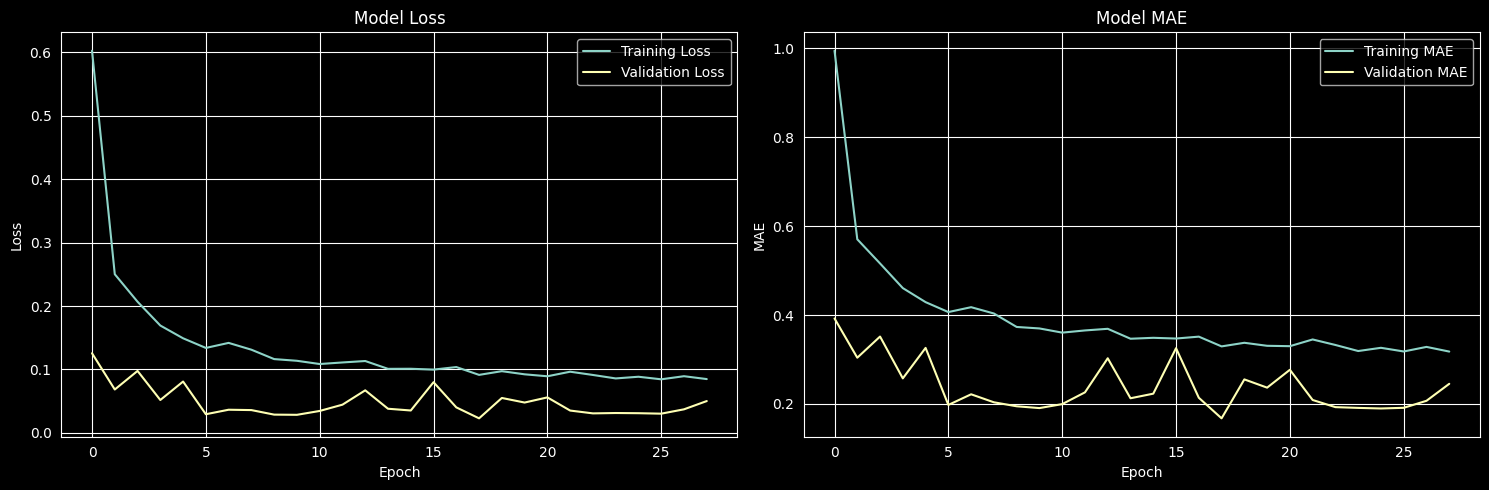

In [32]:
plot_training_history(history)

# Test Model

In [33]:
test_predict_scaled = final_model.predict(X_test_scaled)

predicted_prices = scaler_y.inverse_transform(test_predict_scaled).flatten()
actual_prices = scaler_y.inverse_transform(Y_test_scaled.reshape(-1, 1)).flatten()

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step


In [34]:
test_rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
test_mae = mean_absolute_error(actual_prices, predicted_prices)
test_r2 = r2_score(actual_prices, predicted_prices)
mape = mean_absolute_percentage_error(actual_prices, predicted_prices)

print(f"\n--- Price Prediction Performance Evaluation ---")
print(f"Test Data RMSE: {test_rmse:.4f}")


--- Price Prediction Performance Evaluation ---
Test Data RMSE: 55.8091


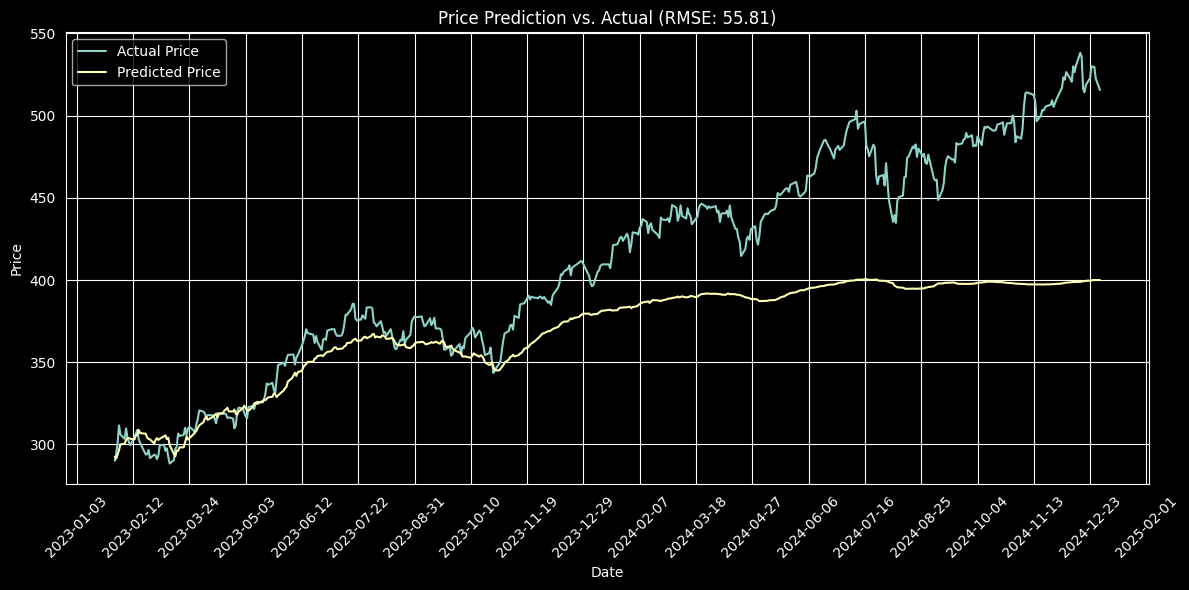

In [35]:
test_dates = df.index[test_start + look_back : test_start + look_back + len(Y_test)]

window = (0,-1)

plt.figure(figsize=(12, 6))
plt.plot(test_dates[window[0]:window[1]], actual_prices[window[0]:window[1]], label='Actual Price')
plt.plot(test_dates[window[0]:window[1]], predicted_prices[window[0]:window[1]], label='Predicted Price')
plt.title(f'Price Prediction vs. Actual (RMSE: {test_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
def comprehensive_evaluation(actual, predicted, test_dates):
    """
    Comprehensive evaluation of model predictions.

    Args:
        actual: actual values array
        predicted: predicted values array
        test_dates: DatetimeIndex for test period
    """
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100  # Convert to percentage

    actual_dir = np.sign(np.diff(actual))
    pred_dir = np.sign(np.diff(predicted))
    dir_acc = accuracy_score((actual_dir > 0).astype(int),
                             (pred_dir > 0).astype(int))

    residuals = actual - predicted

    print("\n=======================================================")
    print("           Transformer Price Performance Metrics         ")
    print("=======================================================")
    print(f"1. RMSE (Root Mean Squared Error):        {rmse:.4f}")
    print(f"2. MAE (Mean Absolute Error):             {mae:.4f}")
    print(f"3. MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    print(f"4. R²:                                    {r2:.4f}")
    print(f"5. Directional Accuracy:                  {dir_acc:.2%}")
    print("=======================================================")

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    axes[0, 0].scatter(actual, predicted, alpha=0.5)
    axes[0, 0].plot([actual.min(), actual.max()],
                    [actual.min(), actual.max()],
                    'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Price')
    axes[0, 0].set_ylabel('Predicted Price')
    axes[0, 0].set_title('Actual vs Predicted')
    axes[0, 0].grid(True)

    axes[0, 1].hist(residuals, bins=50, edgecolor='black')
    axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Residual')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title(f'Residual Distribution (Mean: {residuals.mean():.2f})')
    axes[0, 1].grid(True)

    axes[1, 0].plot(test_dates, residuals)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Residual')
    axes[1, 0].set_title('Residuals Over Time')
    axes[1, 0].xaxis.set_major_locator(plt.MaxNLocator(10))
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True)

    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'directional_accuracy': dir_acc,
        'residual_mean': residuals.mean(),
        'residual_std': residuals.std()
    }


           Transformer Price Performance Metrics         
1. RMSE (Root Mean Squared Error):        55.8091
2. MAE (Mean Absolute Error):             42.0813
3. MAPE (Mean Absolute Percentage Error): 9.18%
4. R²:                                    0.2761
5. Directional Accuracy:                  48.75%


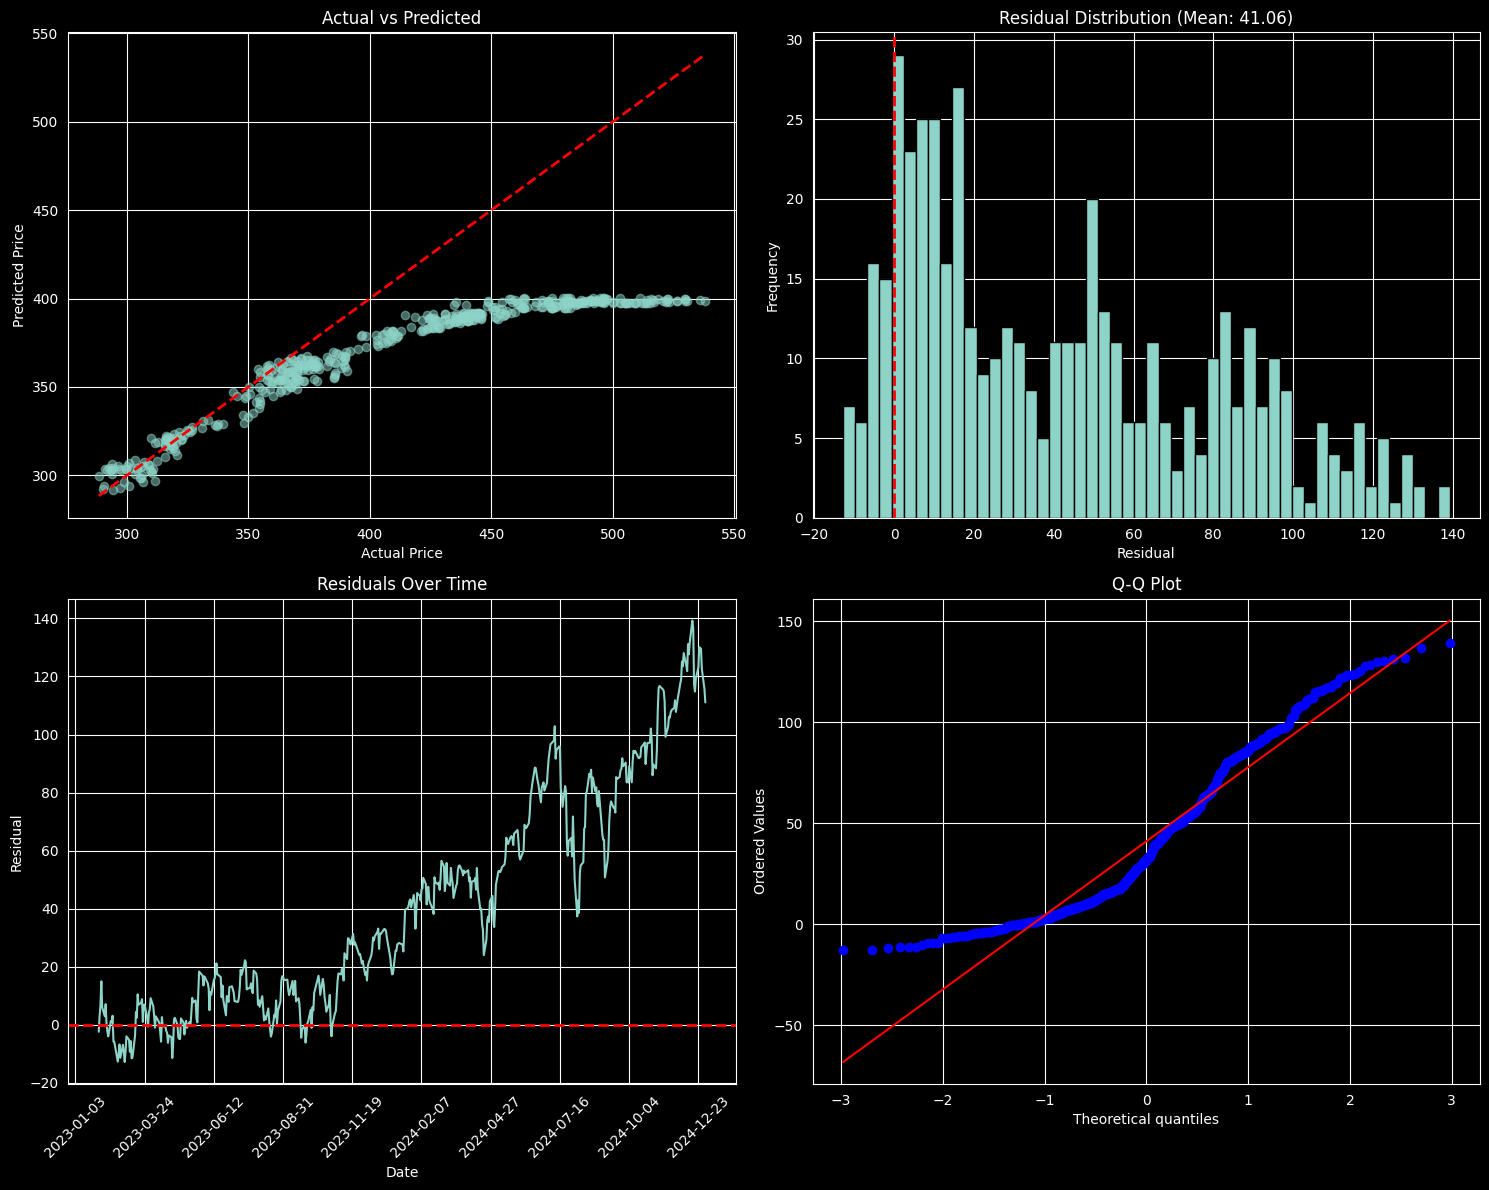

In [37]:
_ = comprehensive_evaluation(actual_prices, predicted_prices, test_dates)

# Model Manager

In [38]:
class ModelManager:
    def __init__(self, model, base_dir="../trained_model"):
        self.model = model
        self.base_dir = base_dir
        tf.io.gfile.makedirs(self.base_dir)

    def save_weights(self, tag):
        file_path = os.path.join(self.base_dir, f"weights_{tag}.h5")
        self.model.save_weights(file_path)
        print(f"Weights saved: {file_path}")
        return file_path

    def load_weights(self, tag):
        file_path = os.path.join(self.base_dir, f"weights_{tag}.h5")
        try:
            self.model.load_weights(file_path)
            print(f"Weights loaded: {file_path}")
            return True
        except Exception as e:
            print(f"Error loading weights: {e}")
            return False

    def save_model(self, tag, save_format='tf'):
        model_path = os.path.join(self.base_dir, f"model_{tag}")
        # save_format: 'tf' -> saved model directory, 'h5' -> single file if desired
        if save_format == 'h5':
            self.model.save(f"{model_path}.h5", include_optimizer=True)
        else:
            self.model.save(model_path)  # SavedModel dir
        print(f"Model saved: {model_path}")
        return model_path

    @staticmethod
    def load_full_model(tag, base_dir="../trained_model"):
        model_path = os.path.join(base_dir, f"model_{tag}")
        try:
            loaded_model = tf.keras.models.load_model(model_path)
            print(f"Model loaded: {model_path}")
            return loaded_model
        except Exception as e:
            print(f"Error loading model: {e}")
            return None

In [39]:
mm = ModelManager(final_model, base_dir=MODEL_DIR)
date = datetime.datetime.now().date()
mm.save_model(f"transformer_{date}", save_format='h5')

Model saved: ../trained_model/model_transformer_2026-02-17


'../trained_model/model_transformer_2026-02-17'

# Further Steps

- Calculate irrationality index based on prediction errors and the actual market movement.
- Error = Actual - Predicted
- I = (Error - Mean(Error)) / StdDev(Error)

# Bias Diagnosis & Correction

In [40]:
# ============================================================
# 1. Train/Test Data Distribution Comparison (Diagnosis)
# ============================================================
print("=" * 60)
print("Target Variable Distribution Analysis")
print("=" * 60)

print(f"\n[Train+Val Period] Y_train_val (Original Scale):")
print(f"  Mean: {Y_train_val.mean():.2f}")
print(f"  Std:  {Y_train_val.std():.2f}")
print(f"  Min:  {Y_train_val.min():.2f}")
print(f"  Max:  {Y_train_val.max():.2f}")

print(f"\n[Test Period] Y_test (Original Scale):")
print(f"  Mean: {Y_test.mean():.2f}")
print(f"  Std:  {Y_test.std():.2f}")
print(f"  Min:  {Y_test.min():.2f}")
print(f"  Max:  {Y_test.max():.2f}")

# Calculate gap between train and test
mean_gap = Y_test.mean() - Y_train_val.mean()
print(f"\n⚠️  Mean Gap (Test - Train): {mean_gap:.2f}")
if mean_gap > 0:
    print("   → Test period prices are higher than training period!")
    print("   → This is likely the cause of systematic under-prediction")

Target Variable Distribution Analysis

[Train+Val Period] Y_train_val (Original Scale):
  Mean: 204.60
  Std:  88.25
  Min:  96.27
  Max:  403.78

[Test Period] Y_test (Original Scale):
  Mean: 409.89
  Std:  65.59
  Min:  288.40
  Max:  538.17

⚠️  Mean Gap (Test - Train): 205.29
   → Test period prices are higher than training period!
   → This is likely the cause of systematic under-prediction



Prediction Bias Analysis
Mean Residual (Bias): 41.0575
Residual Std: 37.8013
Bias as % of Mean Price: 10.02%


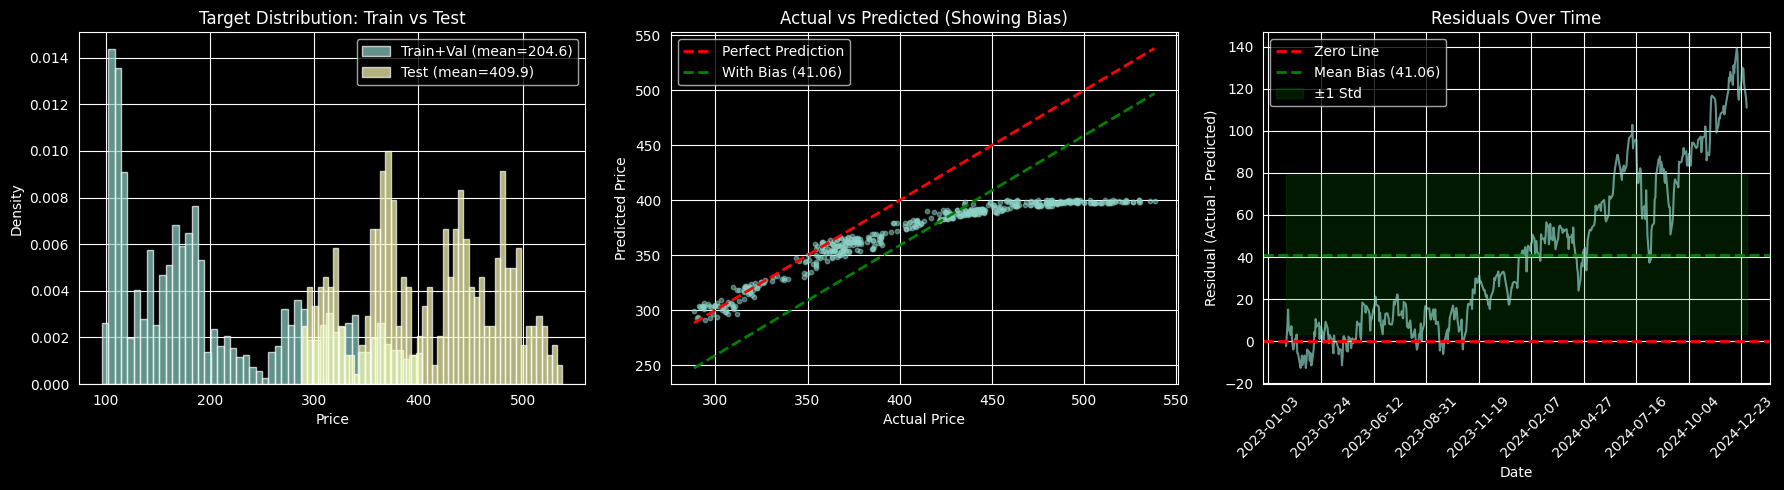

In [41]:
# ============================================================
# 2. Prediction Bias Analysis
# ============================================================
residuals = actual_prices - predicted_prices
bias = residuals.mean()

print("\n" + "=" * 60)
print("Prediction Bias Analysis")
print("=" * 60)
print(f"Mean Residual (Bias): {bias:.4f}")
print(f"Residual Std: {residuals.std():.4f}")
print(f"Bias as % of Mean Price: {(bias / actual_prices.mean()) * 100:.2f}%")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (1) Train/Test data distribution comparison
axes[0].hist(Y_train_val, bins=50, alpha=0.7, label=f'Train+Val (mean={Y_train_val.mean():.1f})', density=True)
axes[0].hist(Y_test, bins=50, alpha=0.7, label=f'Test (mean={Y_test.mean():.1f})', density=True)
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Density')
axes[0].set_title('Target Distribution: Train vs Test')
axes[0].legend()
axes[0].grid(True)

# (2) Predicted vs Actual with bias line
axes[1].scatter(actual_prices, predicted_prices, alpha=0.5, s=10)
axes[1].plot([actual_prices.min(), actual_prices.max()],
             [actual_prices.min(), actual_prices.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[1].plot([actual_prices.min(), actual_prices.max()],
             [actual_prices.min() - bias, actual_prices.max() - bias],
             'g--', lw=2, label=f'With Bias ({bias:.2f})')
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].set_title('Actual vs Predicted (Showing Bias)')
axes[1].legend()
axes[1].grid(True)

# (3) Residuals over time
axes[2].plot(test_dates, residuals, alpha=0.7)
axes[2].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Line')
axes[2].axhline(y=bias, color='g', linestyle='--', linewidth=2, label=f'Mean Bias ({bias:.2f})')
axes[2].fill_between(test_dates, bias - residuals.std(), bias + residuals.std(),
                     alpha=0.2, color='green', label='±1 Std')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Residual (Actual - Predicted)')
axes[2].set_title('Residuals Over Time')
axes[2].legend()
axes[2].xaxis.set_major_locator(plt.MaxNLocator(10))
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [42]:
# ============================================================
# 3. Bias Correction
# ============================================================
print("\n" + "=" * 60)
print("Bias Correction")
print("=" * 60)

# Method 1: Simple Mean Bias Correction
predicted_prices_corrected = predicted_prices + bias

# Compare performance before and after correction
rmse_original = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
rmse_corrected = np.sqrt(mean_squared_error(actual_prices, predicted_prices_corrected))
mae_original = mean_absolute_error(actual_prices, predicted_prices)
mae_corrected = mean_absolute_error(actual_prices, predicted_prices_corrected)

print(f"\n[Before Bias Correction]")
print(f"  RMSE: {rmse_original:.4f}")
print(f"  MAE:  {mae_original:.4f}")

print(f"\n[After Bias Correction]")
print(f"  RMSE: {rmse_corrected:.4f}")
print(f"  MAE:  {mae_corrected:.4f}")

print(f"\n[Improvement]")
print(f"  RMSE: {(1 - rmse_corrected/rmse_original) * 100:.2f}% better")
print(f"  MAE:  {(1 - mae_corrected/mae_original) * 100:.2f}% better")


Bias Correction

[Before Bias Correction]
  RMSE: 55.8091
  MAE:  42.0813

[After Bias Correction]
  RMSE: 37.8013
  MAE:  32.2942

[Improvement]
  RMSE: 32.27% better
  MAE:  23.26% better


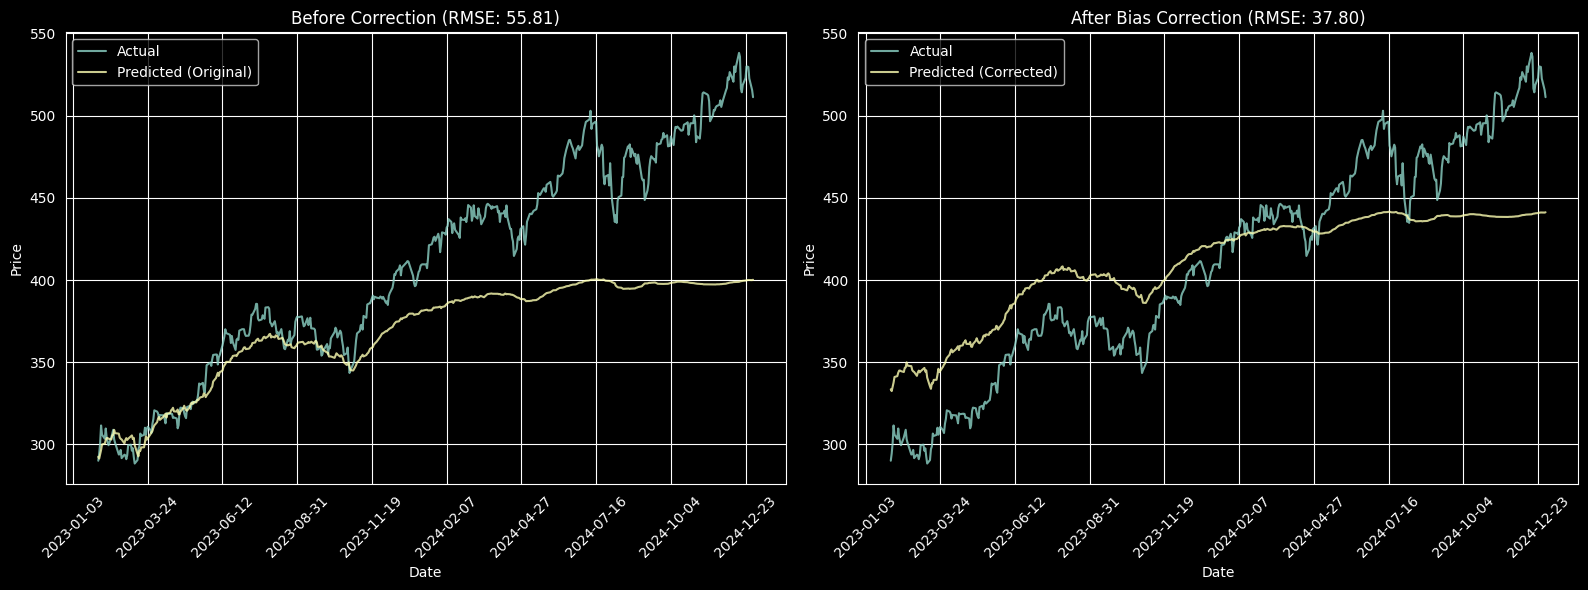

In [43]:
# Before/After correction visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Before correction
axes[0].plot(test_dates, actual_prices, label='Actual', alpha=0.8)
axes[0].plot(test_dates, predicted_prices, label='Predicted (Original)', alpha=0.8)
axes[0].set_title(f'Before Correction (RMSE: {rmse_original:.2f})')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].xaxis.set_major_locator(plt.MaxNLocator(10))
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# After correction
axes[1].plot(test_dates, actual_prices, label='Actual', alpha=0.8)
axes[1].plot(test_dates, predicted_prices_corrected, label='Predicted (Corrected)', alpha=0.8)
axes[1].set_title(f'After Bias Correction (RMSE: {rmse_corrected:.2f})')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].xaxis.set_major_locator(plt.MaxNLocator(10))
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Fundamental Solutions

The above bias correction is a temporary fix. For a fundamental solution:

### Method 1: Predict Returns Instead of Prices
- Returns are stationary, avoiding time-dependent bias

### Method 2: Use Differencing
- Predict price changes and accumulate

### Method 3: Rolling Window Scaler Update
- Update scaler with recent data during testing


Irrationality Index Calculation
Irrationality Index Statistics:
  Mean: 0.0000 (should be ~0)
  Std:  1.0000 (should be ~1)
  Min:  -1.4250
  Max:  2.5978


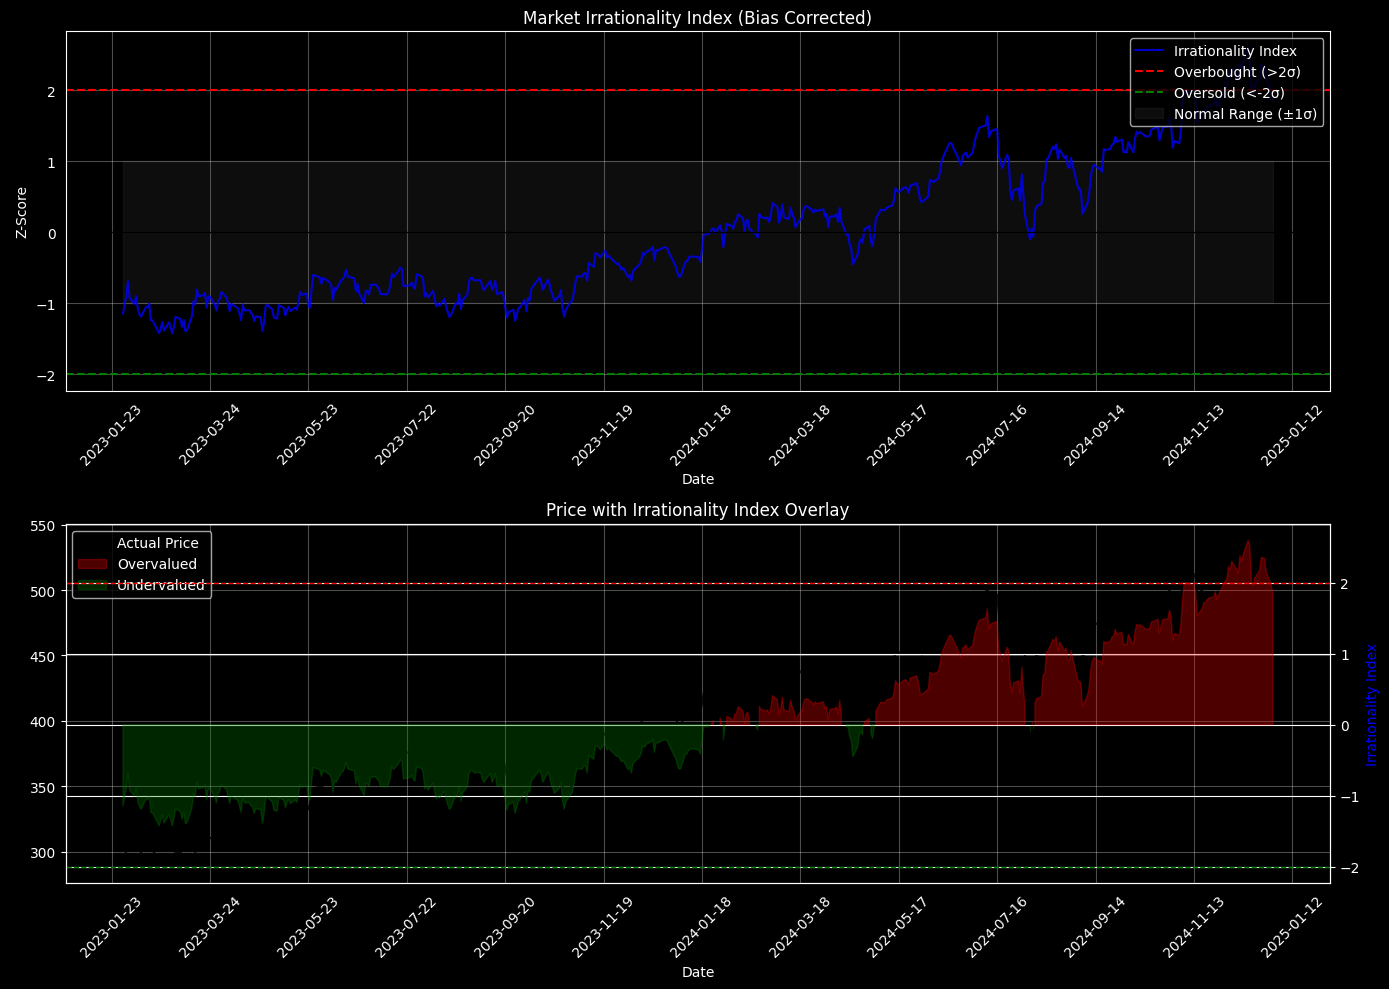

In [44]:
# ============================================================
# Irrationality Index Calculation (After Bias Correction)
# ============================================================
print("\n" + "=" * 60)
print("Irrationality Index Calculation")
print("=" * 60)

# Use bias-corrected residuals
errors_corrected = actual_prices - predicted_prices_corrected
irrationality_index = (errors_corrected - errors_corrected.mean()) / errors_corrected.std()

print(f"Irrationality Index Statistics:")
print(f"  Mean: {irrationality_index.mean():.4f} (should be ~0)")
print(f"  Std:  {irrationality_index.std():.4f} (should be ~1)")
print(f"  Min:  {irrationality_index.min():.4f}")
print(f"  Max:  {irrationality_index.max():.4f}")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# (1) Irrationality index time series
axes[0].plot(test_dates, irrationality_index, label='Irrationality Index', color='blue', alpha=0.8)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0].axhline(y=2, color='red', linestyle='--', linewidth=1.5, label='Overbought (>2σ)')
axes[0].axhline(y=-2, color='green', linestyle='--', linewidth=1.5, label='Oversold (<-2σ)')
axes[0].fill_between(test_dates, -1, 1, alpha=0.1, color='gray', label='Normal Range (±1σ)')
axes[0].set_title('Market Irrationality Index (Bias Corrected)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Z-Score')
axes[0].legend(loc='upper right')
axes[0].xaxis.set_major_locator(plt.MaxNLocator(15))
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# (2) Price with irrationality index overlay
ax1 = axes[1]
ax2 = ax1.twinx()

ax1.plot(test_dates, actual_prices, label='Actual Price', color='black', alpha=0.8)
ax2.fill_between(test_dates, 0, irrationality_index,
                 where=(irrationality_index > 0), color='red', alpha=0.3, label='Overvalued')
ax2.fill_between(test_dates, 0, irrationality_index,
                 where=(irrationality_index < 0), color='green', alpha=0.3, label='Undervalued')
ax2.axhline(y=2, color='red', linestyle='--', linewidth=1)
ax2.axhline(y=-2, color='green', linestyle='--', linewidth=1)

ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color='black')
ax2.set_ylabel('Irrationality Index', color='blue')
ax1.set_title('Price with Irrationality Index Overlay')
ax1.xaxis.set_major_locator(plt.MaxNLocator(15))
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [45]:
# Detect extreme irrationality periods
extreme_high = irrationality_index > 2
extreme_low = irrationality_index < -2

print(f"\nExtreme Market Conditions Detected:")
print(f"  Overbought periods (I > 2): {extreme_high.sum()} days ({extreme_high.mean()*100:.1f}%)")
print(f"  Oversold periods (I < -2): {extreme_low.sum()} days ({extreme_low.mean()*100:.1f}%)")

if extreme_high.any():
    print(f"\nOverbought period dates:")
    for date in test_dates[extreme_high][:5]:  # Show max 5
        print(f"  {date.strftime('%Y-%m-%d')}")
    if extreme_high.sum() > 5:
        print(f"  ... and {extreme_high.sum() - 5} more days")

if extreme_low.any():
    print(f"\nOversold period dates:")
    for date in test_dates[extreme_low][:5]:
        print(f"  {date.strftime('%Y-%m-%d')}")
    if extreme_low.sum() > 5:
        print(f"  ... and {extreme_low.sum() - 5} more days")




Extreme Market Conditions Detected:
  Overbought periods (I > 2): 19 days (4.0%)
  Oversold periods (I < -2): 0 days (0.0%)

Overbought period dates:
  2024-11-08
  2024-12-02
  2024-12-03
  2024-12-04
  2024-12-05
  ... and 14 more days
